In [8]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
#Change for git

In [9]:
# Load the dataset
data = pd.read_csv("../data/interventions_bxl.parquet.csv").drop_duplicates()

# Filter the dataset to only include relevant columns
relevant_data = data[['latitude_permanence', 'longitude_permanence', 
                      'latitude_intervention', 'longitude_intervention', 
                      'vector_type', 'waiting_time']].dropna()

relevant_data = relevant_data[relevant_data['longitude_intervention'] > 4]
relevant_data = relevant_data[relevant_data['latitude_intervention'] > 50]

aed_bxl = pd.read_csv('../data/aed_bxl.parquet.csv')


C:\Users\souna\AppData\Local\Temp\ipykernel_21316\2810076497.py:2: DtypeWarning: Columns (21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/interventions_bxl.parquet.csv").drop_duplicates()


In [10]:
# Concatenate permanence and intervention locations horizontally
locations = pd.concat([relevant_data[['latitude_permanence', 'longitude_permanence']],
                       relevant_data[['latitude_intervention', 'longitude_intervention']]], axis=1)

locations = locations[locations['longitude_intervention'] > 4]
locations = locations[locations['latitude_intervention'] > 50]

# Convert DataFrame to numpy array
X = locations.values

In [12]:
# Compute epsilon using a heuristic based on the distance between points
min_pts = 5  # Minimum number of points in a cluster
epsilon = np.sqrt(2) * np.std(X)  # Heuristic for epsilon

# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.02, min_samples=10, metric='euclidean').fit(X)

# Get the cluster labels
labels = dbscan.labels_

# Find the optimal AED locations as the centroids of the clusters with the lowest waiting time
unique_labels = np.unique(labels)
aed_locations = []
for label in unique_labels:
    if label != -1:  # Ignore noise points
        cluster_points = X[labels == label]
        cluster_waiting_times = relevant_data.iloc[labels == label]['waiting_time']
        weighted_waiting_time = np.sum(cluster_waiting_times) / len(cluster_waiting_times)
        centroid = np.mean(cluster_points, axis=0)
        aed_locations.append((centroid, weighted_waiting_time))

# Sort AED locations based on weighted waiting time
aed_locations.sort(key=lambda x: x[1])

# Center coordinates for Brussels
brussels_center = (50.8503, 4.3517)

# Initialize the map
m = folium.Map(location=brussels_center)

# Add markers for AED locations with custom icon
unique_locations = set()  # Keep track of unique locations added
locations_added = 0  # Track the number of unique locations added
for locations, _ in aed_locations:
    for i in range(0, len(locations), 2):
        lat, lon = locations[i], locations[i + 1]
        if (lat, lon) in zip(aed_bxl['latitude'], aed_bxl['longitude']):
            print(f"Skipping location {lat}, {lon} as it's already in the dataframe")
            continue  # Skip this location if it's already present in the dataframe
        if (lat, lon) in unique_locations:
            continue  # Skip this location if it's already added
        folium.Marker(location=(lat, lon), popup=f"AED Location {locations_added + 1}",
                      icon=folium.CustomIcon('../assets/AED_logo.jpg', icon_size=(32, 32))).add_to(m)
        unique_locations.add((lat, lon))
        locations_added += 1
        if locations_added == 21:  # Stop after adding 5 unique locations
            break
    if locations_added == 21:  # Stop outer loop after adding 5 unique locations
        break


# Save the map to an HTML file
m.save("dbscan_aed_locations_map.html")

           count       mean        std   min    25%   50%    75%    max
Cluster                                                                
0        35559.0  13.434180  10.552299   0.0   8.00  10.0  15.00  367.0
1         3922.0  17.565273  16.835325   1.0   9.00  12.0  21.00  466.0
2         2101.0  16.503570  17.660546   1.0   9.00  12.0  18.00  364.0
3         7395.0  14.098851  11.369104   0.0   8.00  10.0  15.00  212.0
4         2967.0  16.888102  11.820369   1.0  10.00  13.0  19.00  100.0
5         9623.0  13.697496  11.627616   1.0   8.00  10.0  14.00  353.0
6         7440.0  16.092742  12.228929   1.0  10.00  12.0  18.00  274.0
7         1331.0  17.129226  15.946616   1.0   9.00  12.0  18.00  238.0
8         8512.0  14.175399  10.994755   0.0   9.00  11.0  15.00  184.0
9         4223.0  16.383140  13.876358   1.0  10.00  12.0  19.00  435.0
10        1048.0  19.442748  13.699273   1.0  11.00  14.0  25.00   95.0
11        1115.0  15.012556  14.078194   1.0   9.00  11.0  17.00

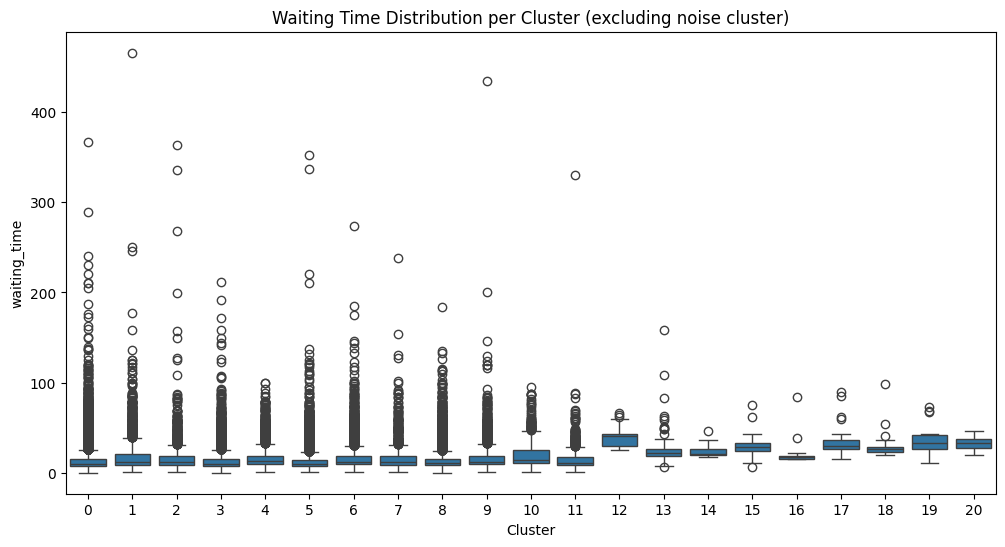

In [13]:
relevant_data['Cluster'] = labels

# Filter out the noise cluster (-1)
relevant_data_filtered = relevant_data[relevant_data['Cluster'] != -1]

relevant_data_filtered = relevant_data_filtered[relevant_data_filtered['waiting_time'] < 600]

# Analyze waiting time per cluster (excluding noise cluster)
cluster_statistics_filtered = relevant_data_filtered.groupby('Cluster')['waiting_time'].describe()

# Print or visualize cluster statistics (excluding noise cluster)
print(cluster_statistics_filtered)

# Visualize Waiting Time Distributions per Cluster (excluding noise cluster)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='waiting_time', data=relevant_data_filtered)
plt.title('Waiting Time Distribution per Cluster (excluding noise cluster)')
plt.show()

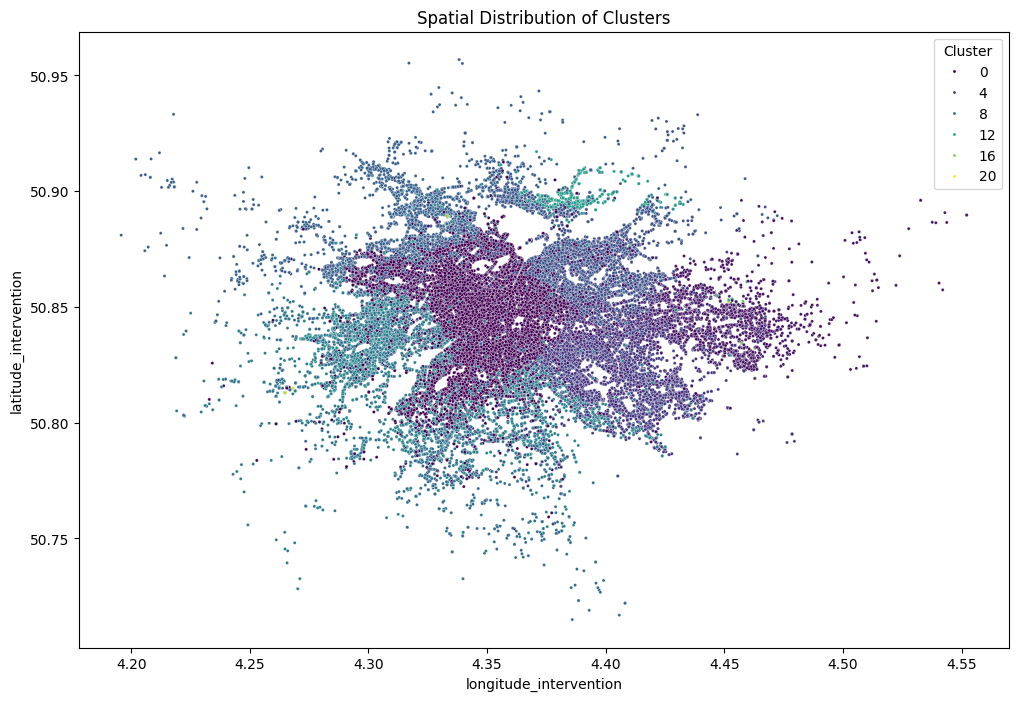

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude_intervention', y='latitude_intervention', hue='Cluster', palette='viridis', s=5, data=relevant_data_filtered)
plt.title('Spatial Distribution of Clusters')
plt.show()

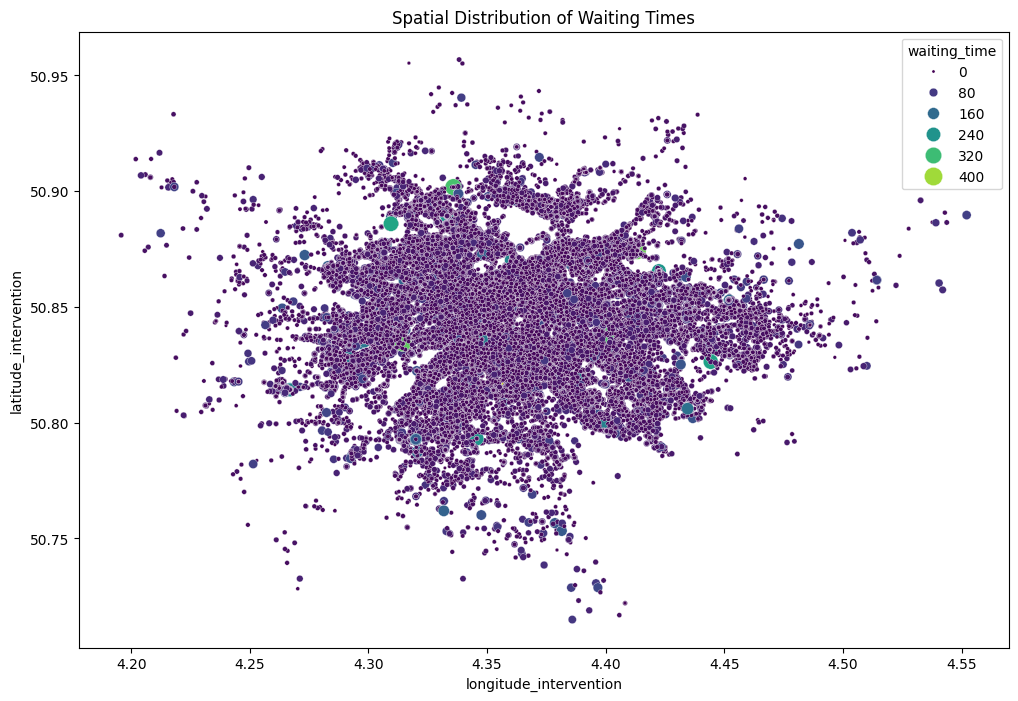

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude_intervention', y='latitude_intervention', hue='waiting_time', palette='viridis', size='waiting_time', sizes=(5, 200), data=relevant_data_filtered)
plt.title('Spatial Distribution of Waiting Times')
plt.show()